In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from json import load
import tifffile
from tqdm import tqdm
from skimage.draw import polygon
from matplotlib import rcParams
from glasbey import create_palette

palette = {
    "green": "#558150",
    "beige": "#F1E2C3",
    "brown": "#A7785A",
    "pink": "#F0D6C2",
    "black": "#0E0E0E",
}

rcParams['font.family'] = 'sans-serif'
rcParams['figure.facecolor'] = "#FFFFFF00"
rcParams['axes.facecolor'] = "#FFFFFF00"
rcParams['legend.framealpha'] = 0.2
rcParams['axes.edgecolor'] = palette["black"]
rcParams['axes.labelcolor'] = palette["black"]
rcParams['xtick.color'] = palette["black"]
rcParams['ytick.color'] = palette["black"]
rcParams['text.color'] = palette["black"]
rcParams['axes.titlecolor'] = palette["black"]

s_palette = sns.cubehelix_palette(as_cmap=True)
pal = sns.color_palette("dark")
cpal = sns.cubehelix_palette(start=-0.25, rot=2, as_cmap=True)
g_palette = create_palette(8000)

In [16]:
source_path = Path(r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_02_06\recon")
# points = pd.read_csv(source_path / "dog_lo2.0_hi7.0_min3_thresh50.0.csv")
tracked_points_path = source_path / "trackedspots.xml"
save_path = source_path / "out"
save_path.mkdir(exist_ok=True)

269it [00:06, 38.81it/s]
11203it [00:04, 2298.05it/s]


starting positional outlier detection
completed positional outlier detection
268.0


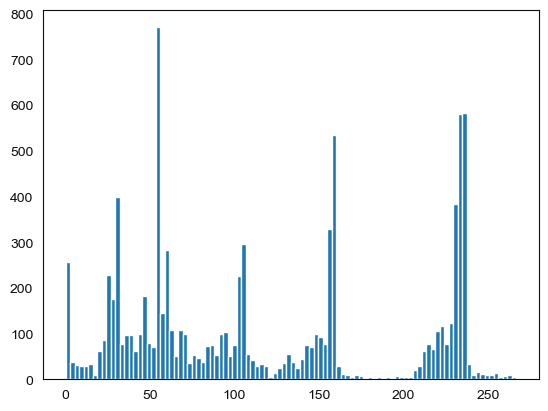

In [17]:
from src.utils.process_trackmate import process_trackmate_tree
from lxml import etree

tree = etree.parse(str(tracked_points_path))
spots_df, graph = process_trackmate_tree(tree)

spots_df["track_id"] = spots_df["track_id"].astype(int)
plt.hist(spots_df.groupby("track_id")["FRAME"].min(), bins=100)
print(spots_df["FRAME"].max())
plt.show()

268.0


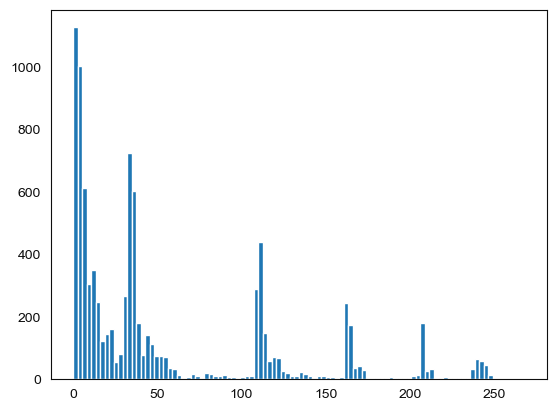

In [18]:
spots_df["track_id"] = spots_df["track_id"].astype(int)
plt.hist(spots_df.groupby("track_id")["FRAME"].max() - spots_df.groupby("track_id")["FRAME"].min(), bins=100)
print(spots_df["FRAME"].max())
plt.show()

count    9096.000000
mean      119.054529
std        78.527786
min         0.000000
25%        55.000000
50%       104.000000
75%       212.000000
max       267.000000
Name: start_time, dtype: float64
          start_time  end_time start_id
track_id                               
0                0.0     268.0  1560631
39               0.0      81.0  1560649
76               0.0     100.0  1560723
127              0.0      78.0  1560748
129              2.0     131.0  1561302
...              ...       ...      ...
4093            69.0      79.0  1612662
4095            69.0      86.0  1612392
4098            69.0      72.0  1612387
4100            69.0      74.0  1612643
4101            69.0     207.0  1612582

[925 rows x 3 columns]
(602, 322)
[[ 13.01093232  18.79678754  20.8486604  ... 384.69540445 398.75761969
  408.55888804]
 [ 25.88494192  28.05810869  29.21378202 ... 363.98700771 367.58749904
  371.60485699]
 [ 20.39183449  21.09970947  24.58281861 ... 374.2756434  387.83196631

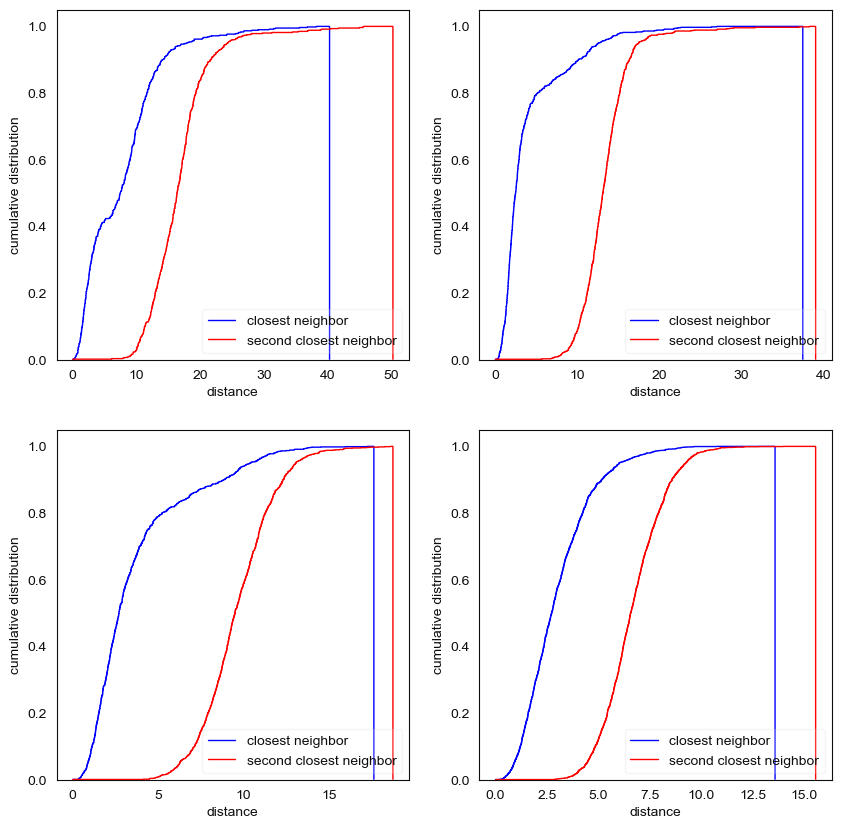

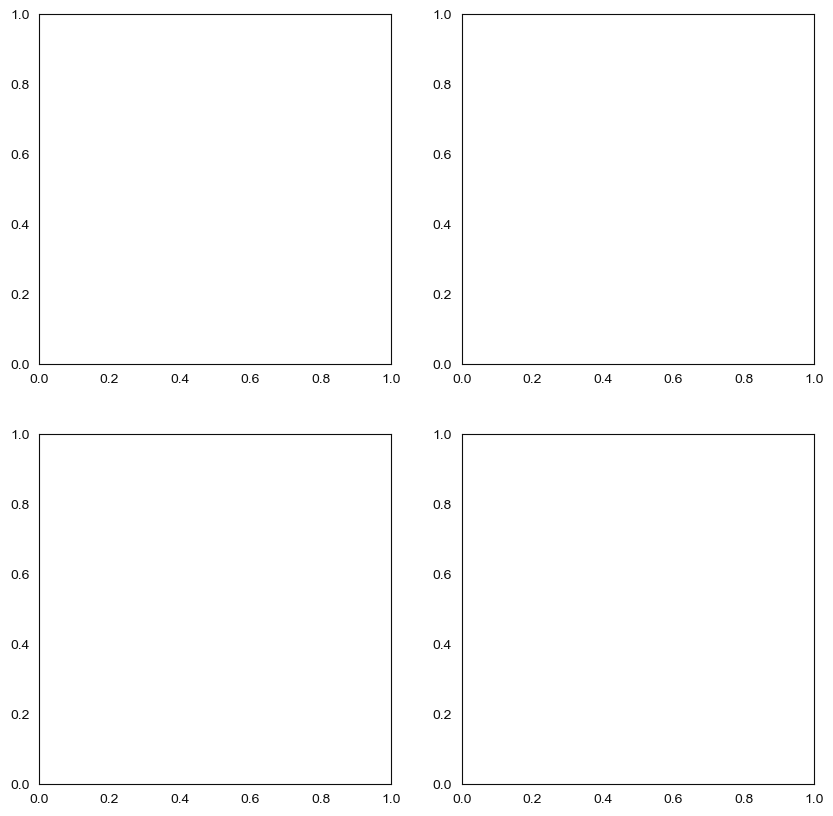

In [19]:
from src.models.division_tracking3d import map_divisions
from scripts.detect_divisions import process_graph

interphase_dividers = [40, 70, 115, 180, 267]

new_graph = map_divisions(spots_df, graph, interphase_dividers, savepath=save_path)
spots_df = process_graph(spots_df, new_graph)
print(spots_df[spots_df["FRAME"] == spots_df["FRAME"].max()].groupby("track_id").size().value_counts())

spots_df.to_csv(save_path / "tracked_spots.csv", index=True)

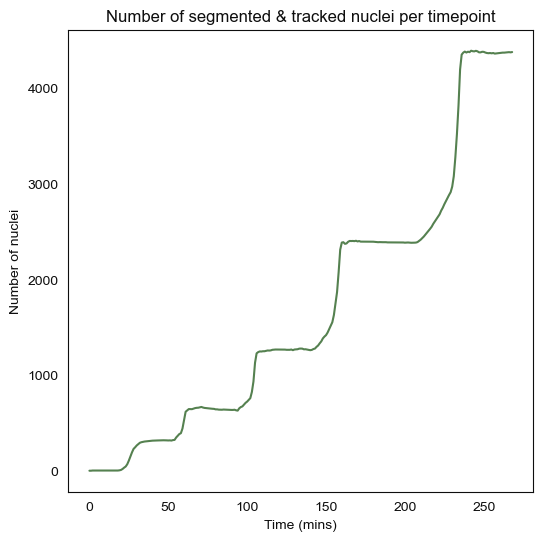

In [7]:
import plotly.express as px

spots_df["reflection_z"] = 2.1*spots_df["POSITION_Z"].max() - spots_df["POSITION_Z"]
spots_df["reflection_x"] = spots_df["POSITION_X"].max() - spots_df["POSITION_X"]

spots_df["is_reflected"] = spots_df["POSITION_X"] > spots_df["POSITION_X"].max() / 2

spots_df["display_x"] = spots_df["reflection_x"]*spots_df["is_reflected"] + spots_df["POSITION_X"]*(~spots_df["is_reflected"])
spots_df["display_z"] = spots_df["reflection_z"]*spots_df["is_reflected"] + spots_df["POSITION_Z"]*(~spots_df["is_reflected"])

fig = px.scatter_3d(spots_df, x='display_x', y='POSITION_Y', z='display_z', color='track_id', animation_frame="FRAME")

fig.update_layout(scene=dict(aspectmode='data'))
fig.write_html(save_path / "allspots.html")

n_tracks = 8000
best_spots = spots_df[spots_df["track_id"] > 0]
n_tracklets = best_spots["track_id"].map(best_spots.groupby("track_id")["tracklet_id"].nunique())
best_spots = best_spots[n_tracklets > 1]
best_spots = best_spots[best_spots["FRAME"] > 10]
# best_spots = best_spots[best_spots["POSITION_X"] < 180]
# best_spots = best_spots[best_spots["POSITION_Y"] < 100]
fig = px.scatter_3d(best_spots, x='display_x', y='POSITION_Y', z='display_z', color='track_id', animation_frame="FRAME", animation_group="tracklet_id", color_continuous_scale=g_palette, range_color=[0, n_tracks])

fig.update_layout(scene=dict(aspectmode='data'))
fig.update_layout(transition={'duration': 100})
fig.update_traces(marker=dict(size=10, colorscale=g_palette), 
                  line=dict(width=50, color='DarkSlateGrey'),
                  )
fig.write_html(save_path / "track_bestspots.html")

plt.figure(figsize=(6, 6))
best_spots = spots_df[spots_df["track_id"] > 0].copy()
n_tracklets = best_spots["track_id"].map(best_spots.groupby("track_id")["tracklet_id"].nunique())
best_spots = best_spots[n_tracklets > 1]
sns.lineplot(best_spots.groupby("FRAME")["track_id"].count(), color=palette["green"])
plt.title("Number of segmented & tracked nuclei per timepoint")
plt.xlabel("Time (mins)")
plt.ylabel("Number of nuclei")
plt.grid(True, which="both")
plt.savefig(save_path / "nuclei_count.png", dpi=300)
plt.show()

In [7]:
# import napari
# from scipy.spatial import Delaunay
# 
# 
# napari_frames = [80, 120, 160, 215, 270]
# viewer = napari.Viewer()
# # 
# # napari_points = best_spots[best_spots["FRAME"] == 270].sample(500)[["POSITION_X", "POSITION_Y", "POSITION_Z"]].values
# # 
# # # contract towards middle
# # center = napari_points.mean(axis=0)
# # napari_points = center + 0.9*(napari_points - center)
# # tri = Delaunay(napari_points)
# # 
# # t_combs = [[0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3]]
# # shapes = []
# # for s in tqdm(tri.simplices):
# #     for comb in t_combs:
# #         shapes.append(napari_points[s[comb]])
# # viewer.add_shapes(shapes, shape_type="polygon", edge_color='white', face_color='white')
# 
# s = [24, 18, 16, 13, 10]
# 
# for frame, size in zip(napari_frames, s):
#     bs = best_spots[best_spots["FRAME"] == frame]
#     viewer.add_points(bs[["display_x", "POSITION_Y", "display_z"]], name=f"frame_{frame}",
#                       face_color=[g_palette[track] for track in bs["track_id"]], size=size*1.2)
#     
# napari.run()

In [1]:
import napari
sz_start = 26
sz_end = 10
f_start = 20
f_end = 245
sz = np.linspace(sz_start, sz_end, f_end - f_start)
viewer = napari.Viewer(ndisplay=3)

tmppath = save_path / "napari_temp"
tmppath.mkdir(exist_ok=True)

for s, frame in zip(sz, range(f_start, f_end)):
    bs = best_spots[best_spots["FRAME"] == frame]
    l = viewer.add_points(bs[["display_x", "POSITION_Y", "display_z"]], name=f"frame_{frame}",
                      face_color=[g_palette[track] for track in bs["track_id"]], size=s, translate=[100, 0, 0])
    viewer.screenshot(str(tmppath / f"frame_{frame}.png"))
    # l.visible = False
    l.refresh()

NameError: name 'np' is not defined

In [9]:
# import plotly.express as px
# 
# xrange = [points['x'].max(), points['x'].min()]
# yrange = [points['y'].max(), points['y'].min()]
# 
# fig = px.scatter_3d(points[points["val"] > 75], x='x', y='y', z='z', color='val', range_x=[0, 150], range_y=yrange, animation_frame="frame")
# fig.update_traces(marker=dict(size=5))
# 
# fig.write_html(save_path / "dog_lo3_hi5.html")

In [10]:
# n_tracks = int(max(tracked_points["TRACK_ID"]))
# g_palette = create_palette(n_tracks)

In [11]:
# import plotly.express as px
# 
# xrange = [points['x'].max(), points['x'].min()]
# yrange = [points['y'].max(), points['y'].min()]
# 
# fig = px.scatter_3d(points, x='x', y='y', z='z', color='val', range_x=xrange, range_y=yrange, animation_frame="frame")
# fig.update_traces(marker=dict(size=5))
# 
# fig.write_html(save_path / "dog_scatter.html")
# 
# fig = px.scatter_3d(tracked_points, x='POSITION_X', y='POSITION_Y', z='POSITION_Z', color='TRACK_ID', range_x=[0, 100], range_y=yrange, animation_frame="FRAME", color_continuous_scale=g_palette, range_color=[0, n_tracks])
# 
# # draw axes in proportion to the proportion of their ranges
# fig.update_layout(scene=dict(aspectmode='manual', aspectratio=dict(x=1, y=points['y'].max()/100, z=points['z'].max()/100)))
# 
# fig.update_traces(marker=dict(size=5, colorscale=g_palette))
# 
# fig.write_html(save_path / "tracked_scatter.html")
#     

In [12]:
# import napari
# from scipy.spatial.distance import cdist
# viewer = napari.Viewer(ndisplay=3)
# 
# bs = best_spots[best_spots["FRAME"] == 240]
# 
# roi = 40
# 
# locs = bs[["POSITION_X", "POSITION_Y", "POSITION_Z"]].values
# distances = cdist(locs, locs)
# density = np.sum(distances < roi, axis=1)
# 
# plt.hist(density, bins=100)
# plt.show()
# 
# ncolors = 20
# 
# density_max = np.quantile(density, 0.98)
# density_min = np.quantile(density, 0.02)
# 
# densities =  np.clip((density - density_min) / (density_max - density_min), 0, 1) 
# print(densities)
# # bs["density_binned"] = pd.cut(density, bins=ncolors)
# 
# pal = sns.color_palette("mako", as_cmap=True)
# 
# viewer.add_points(bs[["display_x", "POSITION_Y", "display_z"]], name=f"frame_{270}", features={"density": densities},
#                       face_color="density", face_colormap="viridis", size=10)
# 
# napari.run()
